In [1]:

import tensorflow as tf

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten,Input,ZeroPadding2D, MaxPooling2D, BatchNormalization, Reshape, LeakyReLU, Conv2D, Dropout, AveragePooling2D, Conv2DTranspose, Activation, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
import time

from IPython import display

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# real_path = '/home/oa04320/Desktop/FYP_Main/Real-Pattern-Dataset'
real_path='flower2'
data = ImageDataGenerator(rescale=1./255)

data_generator = data.flow_from_directory(
        real_path,
        target_size=(256,256),
       # color_mode="grayscale",
        batch_size=32)

Found 80 images belonging to 1 classes.


In [4]:
Images, _ = next(iter(data_generator))
print(Images[2].shape)

(256, 256, 3)


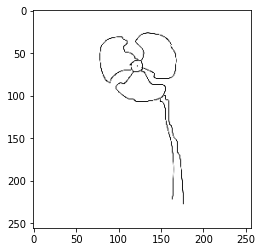

In [5]:
plt.imshow(Images[1])#,cmap="Greys_r")

In [6]:
def discriminator(img_shape=(256,256,3)):

        model = Sequential()

        model.add(Conv2D(32, (5,5), padding='same', input_shape=img_shape)) 
        model.add(LeakyReLU(alpha=0.2)) 
        # downsample to 128x128 
        model.add(Conv2D(64, (5,5), strides=(2,2), padding='same')) 
        model.add(LeakyReLU(alpha=0.2)) 
        # downsample to 64x64 
        model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) 
        model.add(LeakyReLU(alpha=0.2)) 
        # downsample to 32x32 
        model.add(Conv2D(256, (5,5), strides=(2,2), padding='same')) 
        model.add(LeakyReLU(alpha=0.2)) 
        # downsample to 16x16 
        model.add(Conv2D(512, (5,5), strides=(2,2), padding='same')) 
        model.add(LeakyReLU(alpha=0.2)) 
        # downsample to 8x8 
        model.add(Conv2D(1024, (5,5), strides=(2,2), padding='same')) 
        model.add(LeakyReLU(alpha=0.2)) 
        
        model.add(Flatten()) 
        model.add(Dropout(0.4)) 
        model.add(Dense(1, activation='sigmoid')) 

        return model
       

In [7]:
dis = discriminator()
dis.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       8

In [8]:
def generator(latent_dim=100):

        model = Sequential()
        model.add(Dense(1024*8*8, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((8, 8, 1024)))
        # upsample to 16x16
        model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 32x32
        model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 64x64
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 128x128
        model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 256x256
        model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # output layer 256x256x1
        model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))

        return model


In [9]:
gen = generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      8389120   
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      2097408   
 ranspose)                                            

In [10]:
#Combining
optimizer = Adam(0.00002, 0.5)

dis.compile(optimizer=optimizer, loss='binary_crossentropy')
gen.compile(optimizer=optimizer, loss='binary_crossentropy')

#combined model -> latent -> generator -> fakeimage -> (1) -> discriminator -> Loss (which backpropagates to Generator)

def build_combined_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  discriminator.trainable = False
  model.add(discriminator)
  return model

In [11]:
gan = build_combined_gan(gen,dis)
gan.compile(optimizer=Adam(0.0001, 0.5),loss='binary_crossentropy')
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       17796419  
                                                                 
 sequential (Sequential)     (None, 1)                 17529153  
                                                                 
Total params: 35,325,572
Trainable params: 17,796,419
Non-trainable params: 17,529,153
_________________________________________________________________


In [16]:
#Training Loop
batch_size = 32
real = np.ones((batch_size,1), dtype=np.float32)
fake = np.zeros((batch_size,1), dtype=np.float32)


In [ ]:
len_dataset = len(Images)
import math
epochs = 15000
latent_dim = 100
for epoch in range(epochs+1):
  print(epoch, end = ' ')
  #Discriminator train
  for x in range(math.floor(len_dataset/batch_size)):
    print(epoch+x, end = ' ')
    real_ids = np.random.randint(0, Images.shape[0], batch_size)
  
    real_imgs = Images[real_ids]
    noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
    fake_imgs =gen(noise_latent) #Fake Images

    dis.train_on_batch(real_imgs, real)
    dis.train_on_batch(fake_imgs, fake)

    noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
    gan.train_on_batch(noise_latent, real)

  if epoch % 1 == 0:
    noise_latent = np.random.normal(loc=0.0, scale=1.0,size = (1,latent_dim)).astype(np.float32)
    fake_imgs = gen(noise_latent)
    plt.imshow(np.array(fake_imgs[0]),cmap="Greys_r")
    plt.savefig('output '+str(epoch)+'.png')
  

0 

2021-11-29 10:04:58.184125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-29 10:04:58.320843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-29 10:04:58.956482: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2021-11-29 10:04:59.007934: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-29 10:04:59.008065: W tensorflow/str

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183 4184 4185 4186 4187 4188 4189 4190 4191 4192 4193 4194 4195 4196 4197 4198 4199 4200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4501 4502 4503 4504 4505 4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 4516 4517 4518 4519 4520 4521 4522 4523 4524 4525 4526 4527 4528 4529 4530 4531 4532 4533 4534 4535 4536 4537 4538 4539 4540 4541 4542 4543 4544 4545 4546 4547 4548 4549 4550 4551 4552 4553 4554 4555 4556 4557 4558 4559 4560 4561 4562 4563 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573 4574 4575 4576 4577 4578 4579 4580 4581 4582 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615 4616 4617 4618 4619 4620 4621 4622 4623 4624 4625 4626 4627 4628 4629 4630 4631 4632 4633 4634 4635 4636 4637 4638 4639 4640 4641 4642 4643 4644 4645 4646 4647 4648 4649 4650 4651 4652 4653 4654 4655 4656 4657 4658 4659 4660 4661 4662 4663 4664 4665 4666 4667 4668 4669 4670 4671 4672 4673 4674 4675 4676 4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013 5014 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027 5028 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041 5042 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055 5056 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069 5070 5071 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083 5084 5085 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097 5098 5099 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111 5112 5113 5114 5115 5116 5117 5118 5119 5120 5121 5122 5123 5124 5125 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135 5136 5137 5138 5139 5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5501 5502 5503 5504 5505 5506 5507 5508 5509 5510 5511 5512 5513 5514 5515 5516 5517 5518 5519 5520 5521 5522 5523 5524 5525 5526 5527 5528 5529 5530 5531 5532 5533 5534 5535 5536 5537 5538 5539 5540 5541 5542 5543 5544 5545 5546 5547 5548 5549 5550 5551 5552 5553 5554 5555 5556 5557 5558 5559 5560 5561 5562 5563 5564 5565 5566 5567 5568 5569 5570 5571 5572 5573 5574 5575 5576 5577 5578 5579 5580 5581 5582 5583 5584 5585 5586 5587 5588 5589 5590 5591 5592 5593 5594 5595 5596 5597 5598 5599 5600 5601 5602 5603 5604 5605 5606 5607 5608 5609 5610 5611 5612 5613 5614 5615 5616 5617 5618 5619 5620 5621 5622 5623 5624 5625 5626 5627 5628 5629 5630 5631 5632 5633 5634 5635 5636 5637 5638 5639 5640 5641 5642 5643 5644 5645 5646 5647 5648 5649 5650 5651 5652 5653 5654 5655 5656 5657 5658 5659 5660 5661 5662 5663 5664 5665 5666 5667 5668 5669 5670 5671 5672 5673 5674 5675 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685 5686 5687 5688 5689 5690 5691 5692 5693 5694 5695 5696 5697 5698 5699 5700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6001 6002 6003 6004 6005 6006 6007 6008 6009 6010 6011 6012 6013 6014 6015 6016 6017 6018 6019 6020 6021 6022 6023 6024 6025 6026 6027 6028 6029 6030 6031 6032 6033 6034 6035 6036 6037 6038 6039 6040 6041 6042 6043 6044 6045 6046 6047 6048 6049 6050 6051 6052 6053 6054 6055 6056 6057 6058 6059 6060 6061 6062 6063 6064 6065 6066 6067 6068 6069 6070 6071 6072 6073 6074 6075 6076 6077 6078 6079 6080 6081 6082 6083 6084 6085 6086 6087 6088 6089 6090 6091 6092 6093 6094 6095 6096 6097 6098 6099 6100 6101 6102 6103 6104 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115 6116 6117 6118 6119 6120 6121 6122 6123 6124 6125 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136 6137 6138 6139 6140 6141 6142 6143 6144 6145 6146 6147 6148 6149 6150 6151 6152 6153 6154 6155 6156 6157 6158 6159 6160 6161 6162 6163 6164 6165 6166 6167 6168 6169 6170 6171 6172 6173 6174 6175 6176 6177 6178 6179 6180 6181 6182 6183 6184 6185 6186 6187 6188 6189 6190 6191 6192 6193 6194 6195 6196 6197 6198 6199 6200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6501 6502 6503 6504 6505 6506 6507 6508 6509 6510 6511 6512 6513 6514 6515 6516 6517 6518 6519 6520 6521 6522 6523 6524 6525 6526 6527 6528 6529 6530 6531 6532 6533 6534 6535 6536 6537 6538 6539 6540 6541 6542 6543 6544 6545 6546 6547 6548 6549 6550 6551 6552 6553 6554 6555 6556 6557 6558 6559 6560 6561 6562 6563 6564 6565 6566 6567 6568 6569 6570 6571 6572 6573 6574 6575 6576 6577 6578 6579 6580 6581 6582 6583 6584 6585 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597 6598 6599 6600 6601 6602 6603 6604 6605 6606 6607 6608 6609 6610 6611 6612 6613 6614 6615 6616 6617 6618 6619 6620 6621 6622 6623 6624 6625 6626 6627 6628 6629 6630 6631 6632 6633 6634 6635 6636 6637 6638 6639 6640 6641 6642 6643 6644 6645 6646 6647 6648 6649 6650 6651 6652 6653 6654 6655 6656 6657 6658 6659 6660 6661 6662 6663 6664 6665 6666 6667 6668 6669 6670 6671 6672 6673 6674 6675 6676 6677 6678 6679 6680 6681 6682 6683 6684 6685 6686 6687 6688 6689 6690 6691 6692 6693 6694 6695 6696 6697 6698 6699 6700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7001 7002 7003 7004 7005 7006 7007 7008 7009 7010 7011 7012 7013 7014 7015 7016 7017 7018 7019 7020 7021 7022 7023 7024 7025 7026 7027 7028 7029 7030 7031 7032 7033 7034 7035 7036 7037 7038 7039 7040 7041 7042 7043 7044 7045 7046 7047 7048 7049 7050 7051 7052 7053 7054 7055 7056 7057 7058 7059 7060 7061 7062 7063 7064 7065 7066 7067 7068 7069 7070 7071 7072 7073 7074 7075 7076 7077 7078 7079 7080 7081 7082 7083 7084 7085 7086 7087 7088 7089 7090 7091 7092 7093 7094 7095 7096 7097 7098 7099 7100 7101 7102 7103 7104 7105 7106 7107 7108 7109 7110 7111 7112 7113 7114 7115 7116 7117 7118 7119 7120 7121 7122 7123 7124 7125 7126 7127 7128 7129 7130 7131 7132 7133 7134 7135 7136 7137 7138 7139 7140 7141 7142 7143 7144 7145 7146 7147 7148 7149 7150 7151 7152 7153 7154 7155 7156 7157 7158 7159 7160 7161 7162 7163 7164 7165 7166 7167 7168 7169 7170 7171 7172 7173 7174 7175 7176 7177 7178 7179 7180 7181 7182 7183 7184 7185 7186 7187 7188 7189 7190 7191 7192 7193 7194 7195 7196 7197 7198 7199 7200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7501 7502 7503 7504 7505 7506 7507 7508 7509 7510 7511 7512 7513 7514 7515 7516 7517 7518 7519 7520 7521 7522 7523 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534 7535 7536 7537 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548 7549 7550 7551 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562 7563 7564 7565 7566 7567 7568 7569 7570 7571 7572 7573 7574 7575 7576 7577 7578 7579 7580 7581 7582 7583 7584 7585 7586 7587 7588 7589 7590 7591 7592 7593 7594 7595 7596 7597 7598 7599 7600 7601 7602 7603 7604 7605 7606 7607 7608 7609 7610 7611 7612 7613 7614 7615 7616 7617 7618 7619 7620 7621 7622 7623 7624 7625 7626 7627 7628 7629 7630 7631 7632 7633 7634 7635 7636 7637 7638 7639 7640 7641 7642 7643 7644 7645 7646 7647 7648 7649 7650 7651 7652 7653 7654 7655 7656 7657 7658 7659 7660 7661 7662 7663 7664 7665 7666 7667 7668 7669 7670 7671 7672 7673 7674 7675 7676 7677 7678 7679 7680 7681 7682 7683 7684 7685 7686 7687 7688 7689 7690 7691 7692 7693 7694 7695 7696 7697 7698 7699 7700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8001 8002 8003 8004 8005 8006 8007 8008 8009 8010 8011 8012 8013 8014 8015 8016 8017 8018 8019 8020 8021 8022 8023 8024 8025 8026 8027 8028 8029 8030 8031 8032 8033 8034 8035 8036 8037 8038 8039 8040 8041 8042 8043 8044 8045 8046 8047 8048 8049 8050 8051 8052 8053 8054 8055 8056 8057 8058 8059 8060 8061 8062 8063 8064 8065 8066 8067 8068 8069 8070 8071 8072 8073 8074 8075 8076 8077 8078 8079 8080 8081 8082 8083 8084 8085 8086 8087 8088 8089 8090 8091 8092 8093 8094 8095 8096 8097 8098 8099 8100 8101 8102 8103 8104 8105 8106 8107 8108 8109 8110 8111 8112 8113 8114 8115 8116 8117 8118 8119 8120 8121 8122 8123 8124 8125 8126 8127 8128 8129 8130 8131 8132 8133 8134 8135 8136 8137 8138 8139 8140 8141 8142 8143 8144 8145 8146 8147 8148 8149 8150 8151 8152 8153 8154 8155 8156 8157 8158 8159 8160 8161 8162 8163 8164 8165 8166 8167 8168 8169 8170 8171 8172 8173 8174 8175 8176 8177 8178 8179 8180 8181 8182 8183 8184 8185 8186 8187 8188 8189 8190 8191 8192 8193 8194 8195 8196 8197 8198 8199 8200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8501 8502 8503 8504 8505 8506 8507 8508 8509 8510 8511 8512 8513 8514 8515 8516 8517 8518 8519 8520 8521 8522 8523 8524 8525 8526 8527 8528 8529 8530 8531 8532 8533 8534 8535 8536 8537 8538 8539 8540 8541 8542 8543 8544 8545 8546 8547 8548 8549 8550 8551 8552 8553 8554 8555 8556 8557 8558 8559 8560 8561 8562 8563 8564 8565 8566 8567 8568 8569 8570 8571 8572 8573 8574 8575 8576 8577 8578 8579 8580 8581 8582 8583 8584 8585 8586 8587 8588 8589 8590 8591 8592 8593 8594 8595 8596 8597 8598 8599 8600 8601 8602 8603 8604 8605 8606 8607 8608 8609 8610 8611 8612 8613 8614 8615 8616 8617 8618 8619 8620 8621 8622 8623 8624 8625 8626 8627 8628 8629 8630 8631 8632 8633 8634 8635 8636 8637 8638 8639 8640 8641 8642 8643 8644 8645 8646 8647 8648 8649 8650 8651 8652 8653 8654 8655 8656 8657 8658 8659 8660 8661 8662 8663 8664 8665 8666 8667 8668 8669 8670 8671 8672 8673 8674 8675 8676 8677 8678 8679 8680 8681 8682 8683 8684 8685 8686 8687 8688 8689 8690 8691 8692 8693 8694 8695 8696 8697 8698 8699 8700 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9001 9002 9003 9004 9005 9006 9007 9008 9009 9010 9011 9012 9013 9014 9015 9016 9017 9018 9019 9020 9021 9022 9023 9024 9025 9026 9027 9028 9029 9030 9031 9032 9033 9034 9035 9036 9037 9038 9039 9040 9041 9042 9043 9044 9045 9046 9047 9048 9049 9050 9051 9052 9053 9054 9055 9056 9057 9058 9059 9060 9061 9062 9063 9064 9065 9066 9067 9068 9069 9070 9071 9072 9073 9074 9075 9076 9077 9078 9079 9080 9081 9082 9083 9084 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9095 9096 9097 9098 9099 9100 9101 9102 9103 9104 9105 9106 9107 9108 9109 9110 9111 9112 9113 9114 9115 9116 9117 9118 9119 9120 9121 9122 9123 9124 9125 9126 9127 9128 9129 9130 9131 9132 9133 9134 9135 9136 9137 9138 9139 9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153 9154 9155 9156 9157 9158 9159 9160 9161 9162 9163 9164 9165 9166 9167 9168 9169 9170 9171 9172 9173 9174 9175 9176 9177 9178 9179 9180 9181 9182 9183 9184 9185 9186 9187 9188 9189 9190 9191 9192 9193 9194 9195 9196 9197 9198 9199 9200 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10501 10502 10503 10504 10505 10506 10507 10508 10509 10510 10511 10512 10513 10514 10515 10516 10517 10518 10519 10520 10521 10522 10523 10524 10525 10526 10527 10528 10529 10530 10531 10532 10533 10534 10535 10536 10537 10538 10539 10540 10541 10542 10543 10544 10545 10546 10547 10548 10549 10550 10551 10552 10553 10554 10555 10556 10557 10558 10559 10560 10561 10562 10563 10564 10565 10566 10567 10568 10569 10570 10571 10572 10573 10574 10575 10576 10577 10578 10579 10580 10581 10582 10583 10584 10585 10586 10587 10588 10589 10590 10591 10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663 10664 10665 10666 1066

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11001 11002 11003 11004 11005 11006 11007 11008 11009 11010 11011 11012 11013 11014 11015 11016 11017 11018 11019 11020 11021 11022 11023 11024 11025 11026 11027 11028 11029 11030 11031 11032 11033 11034 11035 11036 11037 11038 11039 11040 11041 11042 11043 11044 11045 11046 11047 11048 11049 11050 11051 11052 11053 11054 11055 11056 11057 11058 11059 11060 11061 11062 11063 11064 11065 11066 11067 11068 11069 11070 11071 11072 11073 11074 11075 11076 11077 11078 11079 11080 11081 11082 11083 11084 11085 11086 11087 11088 11089 11090 11091 11092 11093 11094 11095 11096 11097 11098 11099 11100 11101 11102 11103 11104 11105 11106 11107 11108 11109 11110 11111 11112 11113 11114 11115 11116 11117 11118 11119 11120 11121 11122 11123 11124 11125 11126 11127 11128 11129 11130 11131 11132 11133 11134 11135 11136 11137 11138 11139 11140 11141 11142 11143 11144 11145 11146 11147 11148 11149 11150 11151 11152 11153 11154 11155 11156 11157 11158 11159 11160 11161 11162 11163 11164 11165 11166 1116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11501 11502 11503 11504 11505 11506 11507 11508 11509 11510 11511 11512 11513 11514 11515 11516 11517 11518 11519 11520 11521 11522 11523 11524 11525 11526 11527 11528 11529 11530 11531 11532 11533 11534 11535 11536 11537 11538 11539 11540 11541 11542 11543 11544 11545 11546 11547 11548 11549 11550 11551 11552 11553 11554 11555 11556 11557 11558 11559 11560 11561 11562 11563 11564 11565 11566 11567 11568 11569 11570 11571 11572 11573 11574 11575 11576 11577 11578 11579 11580 11581 11582 11583 11584 11585 11586 11587 11588 11589 11590 11591 11592 11593 11594 11595 11596 11597 11598 11599 11600 11601 11602 11603 11604 11605 11606 11607 11608 11609 11610 11611 11612 11613 11614 11615 11616 11617 11618 11619 11620 11621 11622 11623 11624 11625 11626 11627 11628 11629 11630 11631 11632 11633 11634 11635 11636 11637 11638 11639 11640 11641 11642 11643 11644 11645 11646 11647 11648 11649 11650 11651 11652 11653 11654 11655 11656 11657 11658 11659 11660 11661 11662 11663 11664 11665 11666 1166

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12001 12002 12003 12004 12005 12006 12007 12008 12009 12010 12011 12012 12013 12014 12015 12016 12017 12018 12019 12020 12021 12022 12023 12024 12025 12026 12027 12028 12029 12030 12031 12032 12033 12034 12035 12036 12037 12038 12039 12040 12041 12042 12043 12044 12045 12046 12047 12048 12049 12050 12051 12052 12053 12054 12055 12056 12057 12058 12059 12060 12061 12062 12063 12064 12065 12066 12067 12068 12069 12070 12071 12072 12073 12074 12075 12076 12077 12078 12079 12080 12081 12082 12083 12084 12085 12086 12087 12088 12089 12090 12091 12092 12093 12094 12095 12096 12097 12098 12099 12100 12101 12102 12103 12104 12105 12106 12107 12108 12109 12110 12111 12112 12113 12114 12115 12116 12117 12118 12119 12120 12121 12122 12123 12124 12125 12126 12127 12128 12129 12130 12131 12132 12133 12134 12135 12136 12137 12138 12139 12140 12141 12142 12143 12144 12145 12146 12147 12148 12149 12150 12151 12152 12153 12154 12155 12156 12157 12158 12159 12160 12161 12162 12163 12164 12165 12166 1216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12501 12502 12503 12504 12505 12506 12507 12508 12509 12510 12511 12512 12513 12514 12515 12516 12517 12518 12519 12520 12521 12522 12523 12524 12525 12526 12527 12528 12529 12530 12531 12532 12533 12534 12535 12536 12537 12538 12539 12540 12541 12542 12543 12544 12545 12546 12547 12548 12549 12550 12551 12552 12553 12554 12555 12556 12557 12558 12559 12560 12561 12562 12563 12564 12565 12566 12567 12568 12569 12570 12571 12572 12573 12574 12575 12576 12577 12578 12579 12580 12581 12582 12583 12584 12585 12586 12587 12588 12589 12590 12591 12592 12593 12594 12595 12596 12597 12598 12599 12600 12601 12602 12603 12604 12605 12606 12607 12608 12609 12610 12611 12612 12613 12614 12615 12616 12617 12618 12619 12620 12621 12622 12623 12624 12625 12626 12627 12628 12629 12630 12631 12632 12633 12634 12635 12636 12637 12638 12639 12640 12641 12642 12643 12644 12645 12646 12647 12648 12649 12650 12651 12652 12653 12654 12655 12656 12657 12658 12659 12660 12661 12662 12663 12664 12665 12666 1266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13001 13002 13003 13004 13005 13006 13007 13008 13009 13010 13011 13012 13013 13014 13015 13016 13017 13018 13019 13020 13021 13022 13023 13024 13025 13026 13027 13028 13029 13030 13031 13032 13033 13034 13035 13036 13037 13038 13039 13040 13041 13042 13043 13044 13045 13046 13047 13048 13049 13050 13051 13052 13053 13054 13055 13056 13057 13058 13059 13060 13061 13062 13063 13064 13065 13066 13067 13068 13069 13070 13071 13072 13073 13074 13075 13076 13077 13078 13079 13080 13081 13082 13083 13084 13085 13086 13087 13088 13089 13090 13091 13092 13093 13094 13095 13096 13097 13098 13099 13100 13101 13102 13103 13104 13105 13106 13107 13108 13109 13110 13111 13112 13113 13114 13115 13116 13117 13118 13119 13120 13121 13122 13123 13124 13125 13126 13127 13128 13129 13130 13131 13132 13133 13134 13135 13136 13137 13138 13139 13140 13141 13142 13143 13144 13145 13146 13147 13148 13149 13150 13151 13152 13153 13154 13155 13156 13157 13158 13159 13160 13161 13162 13163 13164 13165 13166 1316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13501 13502 13503 13504 13505 13506 13507 13508 13509 13510 13511 13512 13513 13514 13515 13516 13517 13518 13519 13520 13521 13522 13523 13524 13525 13526 13527 13528 13529 13530 13531 13532 13533 13534 13535 13536 13537 13538 13539 13540 13541 13542 13543 13544 13545 13546 13547 13548 13549 13550 13551 13552 13553 13554 13555 13556 13557 13558 13559 13560 13561 13562 13563 13564 13565 13566 13567 13568 13569 13570 13571 13572 13573 13574 13575 13576 13577 13578 13579 13580 13581 13582 13583 13584 13585 13586 13587 13588 13589 13590 13591 13592 13593 13594 13595 13596 13597 13598 13599 13600 13601 13602 13603 13604 13605 13606 13607 13608 13609 13610 13611 13612 13613 13614 13615 13616 13617 13618 13619 13620 13621 13622 13623 13624 13625 13626 13627 13628 13629 13630 13631 13632 13633 13634 13635 13636 13637 13638 13639 13640 13641 13642 13643 13644 13645 13646 13647 13648 13649 13650 13651 13652 13653 13654 13655 13656 13657 13658 13659 13660 13661 13662 13663 13664 13665 13666 1366

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14001 14002 14003 14004 14005 14006 14007 14008 14009 14010 14011 14012 14013 14014 14015 14016 14017 14018 14019 14020 14021 14022 14023 14024 14025 14026 14027 14028 14029 14030 14031 14032 14033 14034 14035 14036 14037 14038 14039 14040 14041 14042 14043 14044 14045 14046 14047 14048 14049 14050 14051 14052 14053 14054 14055 14056 14057 14058 14059 14060 14061 14062 14063 14064 14065 14066 14067 14068 14069 14070 14071 14072 14073 14074 14075 14076 14077 14078 14079 14080 14081 14082 14083 14084 14085 14086 14087 14088 14089 14090 14091 14092 14093 14094 14095 14096 14097 14098 14099 14100 14101 14102 14103 14104 14105 14106 14107 14108 14109 14110 14111 14112 14113 14114 14115 14116 14117 14118 14119 14120 14121 14122 14123 14124 14125 14126 14127 14128 14129 14130 14131 14132 14133 14134 14135 14136 14137 14138 14139 14140 14141 14142 14143 14144 14145 14146 14147 14148 14149 14150 14151 14152 14153 14154 14155 14156 14157 14158 14159 14160 14161 14162 14163 14164 14165 14166 1416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14501 14502 14503 14504 14505 14506 14507 14508 14509 14510 14511 14512 14513 14514 14515 14516 14517 14518 14519 14520 14521 14522 14523 14524 14525 14526 14527 14528 14529 14530 14531 14532 14533 14534 14535 14536 14537 14538 14539 14540 14541 14542 14543 14544 14545 14546 14547 14548 14549 14550 14551 14552 14553 14554 14555 14556 14557 14558 14559 14560 14561 14562 14563 14564 14565 14566 14567 14568 14569 14570 14571 14572 14573 14574 14575 14576 14577 14578 14579 14580 14581 14582 14583 14584 14585 14586 14587 14588 14589 14590 14591 14592 14593 14594 14595 14596 14597 14598 14599 14600 14601 14602 14603 14604 14605 14606 14607 14608 14609 14610 14611 14612 14613 14614 14615 14616 14617 14618 14619 14620 14621 14622 14623 14624 14625 14626 14627 14628 14629 14630 14631 14632 14633 14634 14635 14636 14637 14638 14639 14640 14641 14642 14643 14644 14645 14646 14647 14648 14649 14650 14651 14652 14653 14654 14655 14656 14657 14658 14659 14660 14661 14662 14663 14664 14665 14666 1466

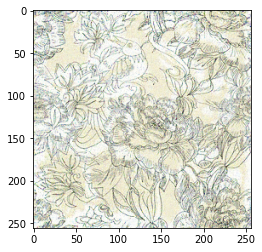

In [ ]:
# epochs = 15000
# latent_dim = 100
# for epoch in range(epochs):
#   print(epoch, end = ' ')
#   #Discriminator train
#   real_ids = np.random.randint(0, Images.shape[0], batch_size)
 
#   real_imgs = Images[real_ids]
#   noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
#   fake_imgs =gen(noise_latent) #Fake Images

#   dis.train_on_batch(real_imgs, real)
#   dis.train_on_batch(fake_imgs, fake)

#   noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
#   gan.train_on_batch(noise_latent, real)

#   if epoch % 500 == 0:
#     noise_latent = np.random.normal(loc=0.0, scale=1.0,size = (1,latent_dim)).astype(np.float32)
#     fake_imgs = gen(noise_latent)
#     plt.imshow(np.array(fake_imgs[0]),cmap="Greys_r")
#     plt.savefig('output '+str(epoch)+'.png')
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

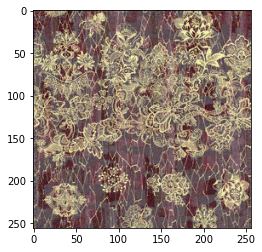

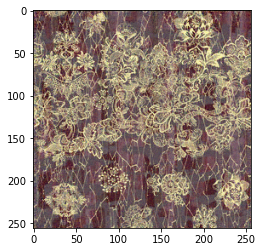

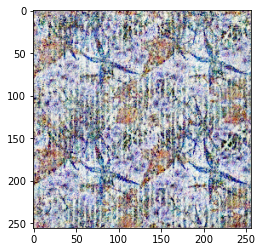

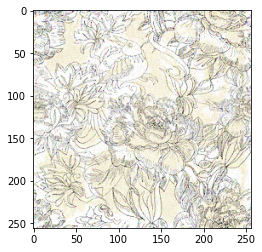

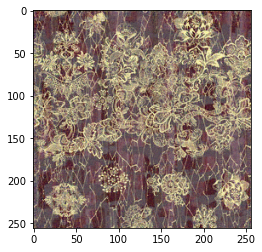

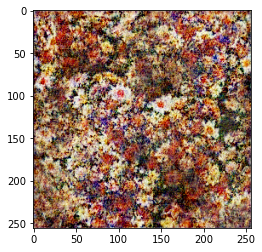

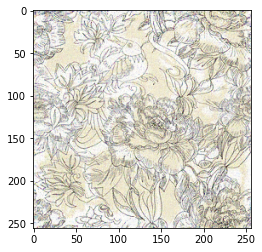

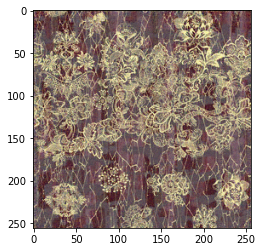

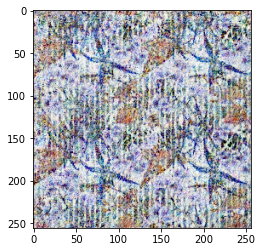

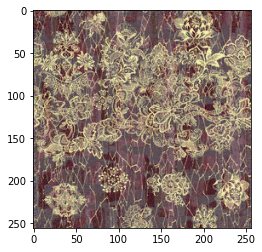

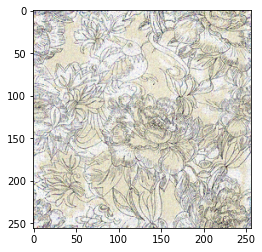

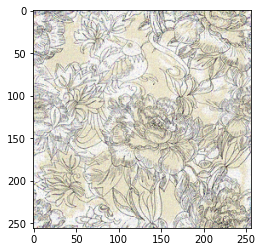

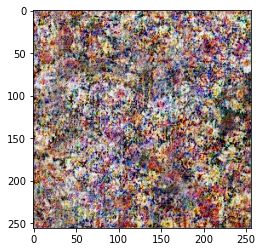

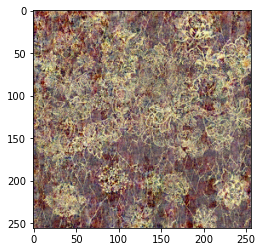

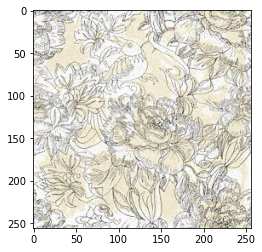

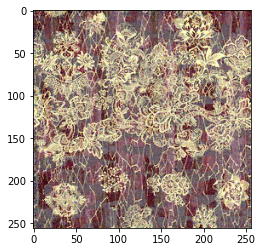

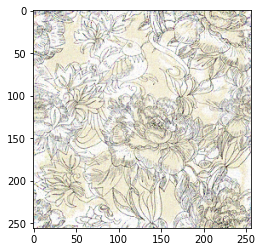

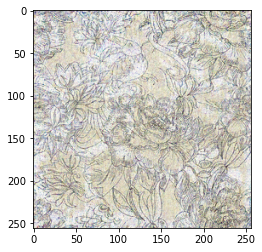

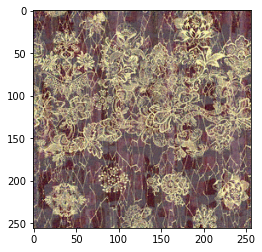

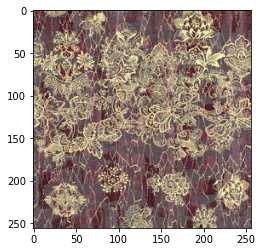

<Figure size 432x288 with 0 Axes>

In [ ]:
for x in range(20):
  noise_latent = np.random.normal(loc=0.0, scale=1.0,size = (1,latent_dim)).astype(np.float32)
  fake_imgs = gen(noise_latent)
  plt.imshow(np.array(fake_imgs[0]),cmap="Greys_r")
  plt.figure()